In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from datasets.dataset import AdvBehaviorsConfig, Dataset

In [2]:
d = Dataset.from_name("adv_behaviors")(
    AdvBehaviorsConfig(
        "adv_behaviors",
        messages_path="/nfs/staff-ssd/beyer/llm-quick-check/data/behavior_datasets/harmbench_behaviors_text_all.csv",
        targets_path="/nfs/staff-ssd/beyer/llm-quick-check/data/optimizer_targets/harmbench_targets_text.json",
        seed=0,
        categories=[
            "chemical_biological",
            "illegal",
            "misinformation_disinformation",
            "harmful",
            "harassment_bullying",
            "cybercrime_intrusion",
        ],
    )
)


In [12]:
def process_file(path):
    try:
        data = pd.read_json(path)
        return [data.iloc[i] for i in range(len(data))]
    except ValueError as e:
        raise ValueError(f'Error in {os.path.join(root, file)} with {e}')


data_path = '../outputs'

paths = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('run.json'):
            paths.append(os.path.join(root, file))
runs = Parallel(n_jobs=16)(delayed(process_file)(path) for path in paths)
attack_runs = [r for run in runs for r in run]

print(f'Found {len(attack_runs)} runs.')
print(f'In total {sum(len(run["attacks"]) for run in attack_runs)} prompt attacks.')

Found 10412 runs.
In total 14669 prompt attacks.


In [13]:
prompts = []
for run in attack_runs:
    prompts.extend([p['content'] for p in run["prompts"]])
prompts = set(prompts)

# for each prompt, we will store all attacks that applied to it
indexed_attack_runs: dict[str, list[dict]] = defaultdict(list)
models = set()
attacks = set()
n_unjudged = 0
for run in attack_runs:
    config = run['config']
    model = config['model']
    models.add(model)
    dataset = config['dataset']
    attacks.add(config['attack'])
    if 'successes_cais' not in run or isinstance(run['successes_cais'], float):
        print(f"WARNING: Skipping unjudged run: {run['config']['model'], run['config']['attack'], run['config']['dataset'], run['config']['dataset_params']['idx']}")
        n_unjudged += len(run['attacks'])
        continue

    for attack, loss, prompt, completion, success in zip(run['attacks'], run['losses'], run['prompts'], run['completions'], run['successes_cais']):
        indexed_attack_runs[prompt['content']].append({
            'config': config,
            'model': model,
            'attack': attack,
            'dataset': dataset,
            'loss': loss,
            'completion': completion,
            'success': [s == 'Yes' for s in success]
        })
print(f'Found {len(indexed_attack_runs)} prompts.')
print(f'Total judged attacks: {sum([len(v) for v in indexed_attack_runs.values()])}, unjudged attacks: {n_unjudged}.')

Found 329 prompts.
Total judged attacks: 14365


# Find missing attacks

Did we attack `model` with `attack` across all prompts yet?

In [14]:
prompt_to_idx = {prompt[0]['content']: idx for idx, prompt in enumerate(d)}
timeouts = {
    'autodan': 480,
    'gcg': 240,
    'pgd': 30,  # 2 min IRL
    'human_jailbreaks': 50,
    'pgd_one_hot': 30,
    'ample_gcg': 120,
    'direct': 10,
    'pair': 30
}

tgt_models = 'all' #'meta-llama/Meta-Llama-3.1-8B-Instruct'
tgt_attacks = 'human_jailbreaks' #'all'
n = 0
for tgt_model in models if tgt_models == 'all' else [tgt_models]:
    for tgt_attack in attacks if tgt_attacks == 'all' else [tgt_attacks]:
        idx = []
        for prompt, runs in indexed_attack_runs.items():
            models_attacks = set((run['config']['model'], run['config']['attack']) for run in runs)
            if (tgt_model, tgt_attack) not in models_attacks:
                try:
                    idx.append(prompt_to_idx[prompt])
                except KeyError:
                    # prompt from jbb
                    pass
        if idx:
            n += len(idx)
            template = "python run_attacks.py -m ++model_name={tgt_model} ++attack_name={tgt_attack} ++datasets.adv_behaviors.idx={idx} ++dataset_name=adv_behaviors ++hydra.launcher.timeout_min={timeout}"
            idx = ','.join(map(str, sorted(idx)))
            print(template.format(tgt_model=tgt_model, idx=idx, tgt_attack=tgt_attack, timeout=timeouts[tgt_attack]))
if n > 0:
    print(f"Total: {n} attacks.")

python run_attacks.py -m ++model_name=mistralai/Mistral-7B-Instruct-v0.3 ++attack_name=human_jailbreaks ++datasets.adv_behaviors.idx=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,2

## Visualize

In [76]:
from functools import lru_cache

@lru_cache
def get_color_for_run(model_type: str, attack_type: str):
    # Define a base color for each model (7 options)

    model_colors = {
        k: v
        for k, v in zip(
            set([run["config"]["model"] for run in attack_runs]),
            (
                (255, 0, 0),
                (255, 135, 0),
                (255, 211, 0),
                (222, 255, 10),
                (161, 255, 10),
                (10, 255, 153),
                (10, 239, 255),
                (20, 125, 245),
                (88, 10, 255),
                (190, 10, 255),
                (255, 10, 235),
                (255, 10, 60),
                (255, 10, 10),
                (10, 10, 255),
            ),
        )
    }

    # Define a variation for each attack type
    attack_variation = {
        "autodan": 0.4,
        "human_jailbreaks": 0.5,
        "ample_gcg": 0.6,
        "pgd": 0.7,
        "pair": 0.8,
        "pgd_one_hot": 0.85,
        "direct": 0.9,
        "gcg": 1.0,
    }

    # Get the base color for the model
    base_color = np.array(model_colors[model_type])

    # Adjust the color based on the attack type (by scaling the brightness)
    adjusted_color = np.clip(base_color * attack_variation[attack_type], 0, 255) / 255.0

    return adjusted_color


def ragged_mean(sequences):
    # Find the maximum length of the sequences
    max_len = max(len(seq) for seq in sequences)

    # Pad sequences with NaN to make them the same length
    padded_sequences = np.full((len(sequences), max_len), np.nan)

    for i, seq in enumerate(sequences):
        padded_sequences[i, : len(seq)] = seq

    return np.nanmean(padded_sequences, axis=0)


def filter_runs(runs, model_name=None, attack_type=None):
    filtered_runs = []
    for run in runs:
        if model_name is None:
            pass
        elif (
            isinstance(model_name, str) and model_name in run["config"]["model"].lower()
        ):
            pass
        elif isinstance(model_name, list) and any(
            m in run["config"]["model"].lower() for m in model_name
        ):
            pass
        else:
            continue
        if attack_type is None:
            pass
        elif (
            isinstance(attack_type, str)
            and attack_type == run["config"]["attack"].lower()
        ):
            pass
        elif isinstance(attack_type, list) and any(
            m == run["config"]["attack"].lower() for m in attack_type
        ):
            pass
        else:
            continue
        filtered_runs.append(run)
    return filtered_runs

In [77]:
def plot_prompts(prompts, metric='loss', model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    n = 0
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)

        for run in prompt_runs:
            key = (run['config']['model'], run['config']['attack'])
            to_plot.setdefault(key, []).append(run[metric])

    plt.figure(figsize=(12, 6))
    for key, values in to_plot.items():
        model, attack = key

        for value in values:
            plt.plot(value, alpha=min(0.15, (1.5/len(values))), c=get_color_for_run(model, attack))
        plt.plot(ragged_mean(values), label=f"{model} | {attack}", c=get_color_for_run(model, attack))
        n += len(values)

    if metric == 'loss':
        plt.yscale('log')
        # plt.yscale('symlog')
    plt.title(f"{metric} for {n} runs across {len(prompts)} prompts, model={model_name if model_name is not None else "All"}, attack={attack_type}")
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.xlabel("Step")
    plt.legend(loc='lower left')
    plt.tight_layout()

## AmpleGCG makes 200 'steps' in parallel, so they should all have approx equal success:

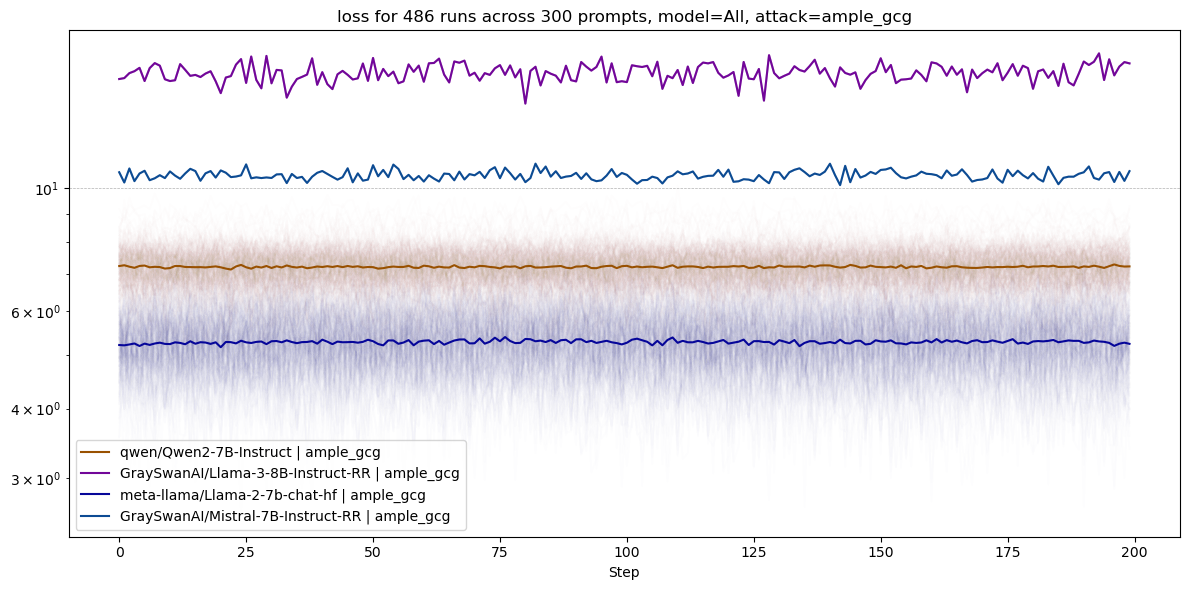

In [78]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='ample_gcg')

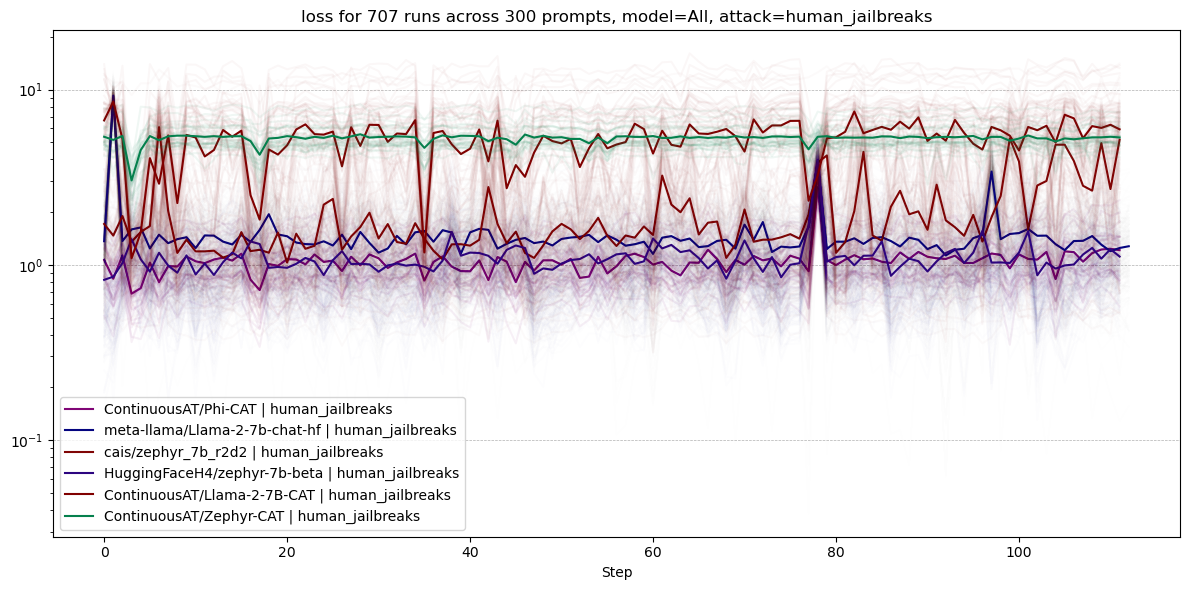

In [79]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='human_jailbreaks')

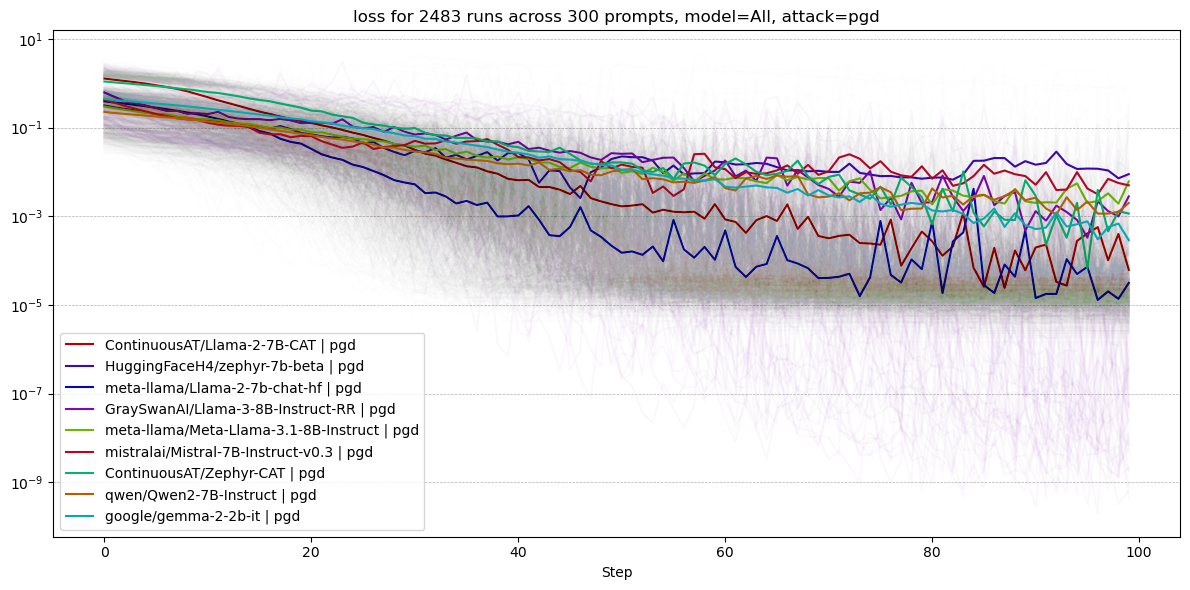

In [80]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='pgd')

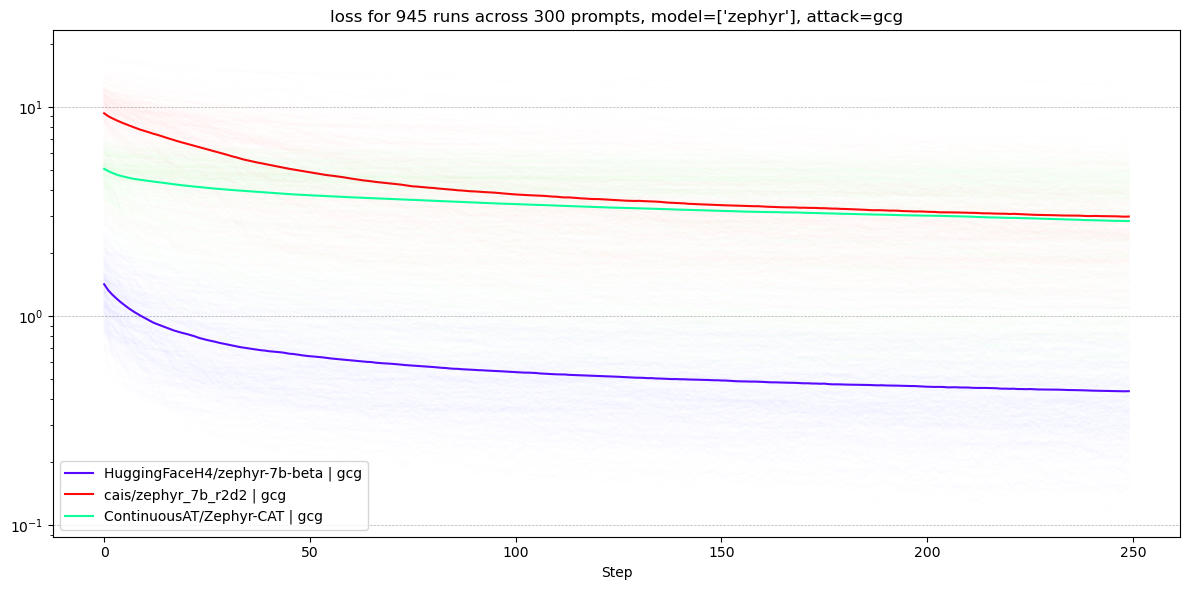

In [81]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=['zephyr'], attack_type='gcg')

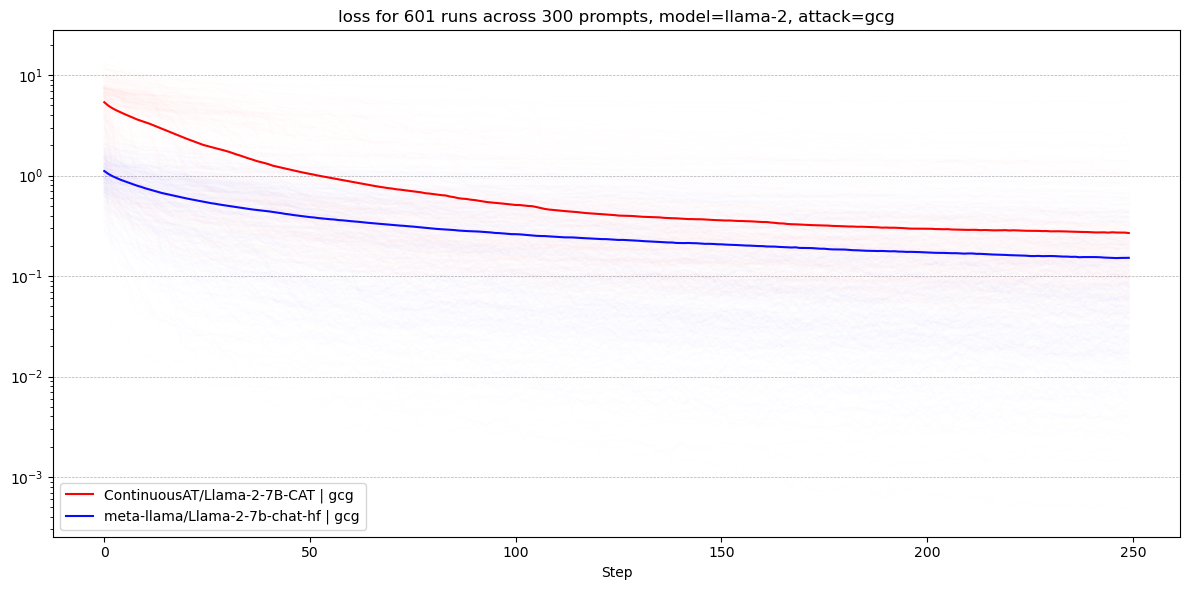

In [82]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name='llama-2', attack_type='gcg')

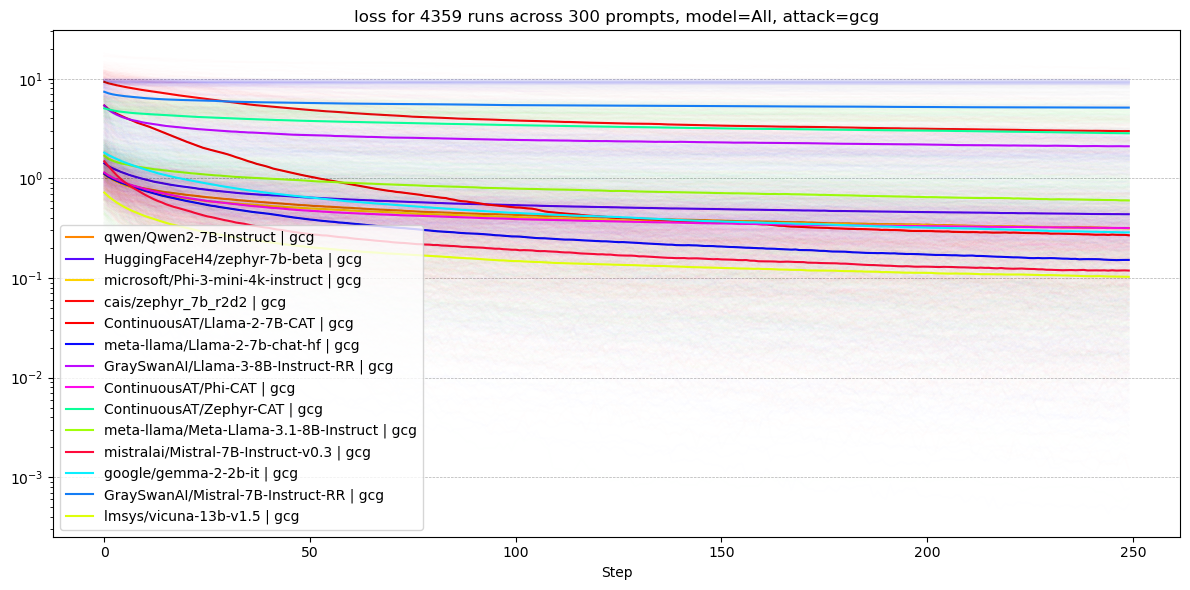

In [83]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='gcg')

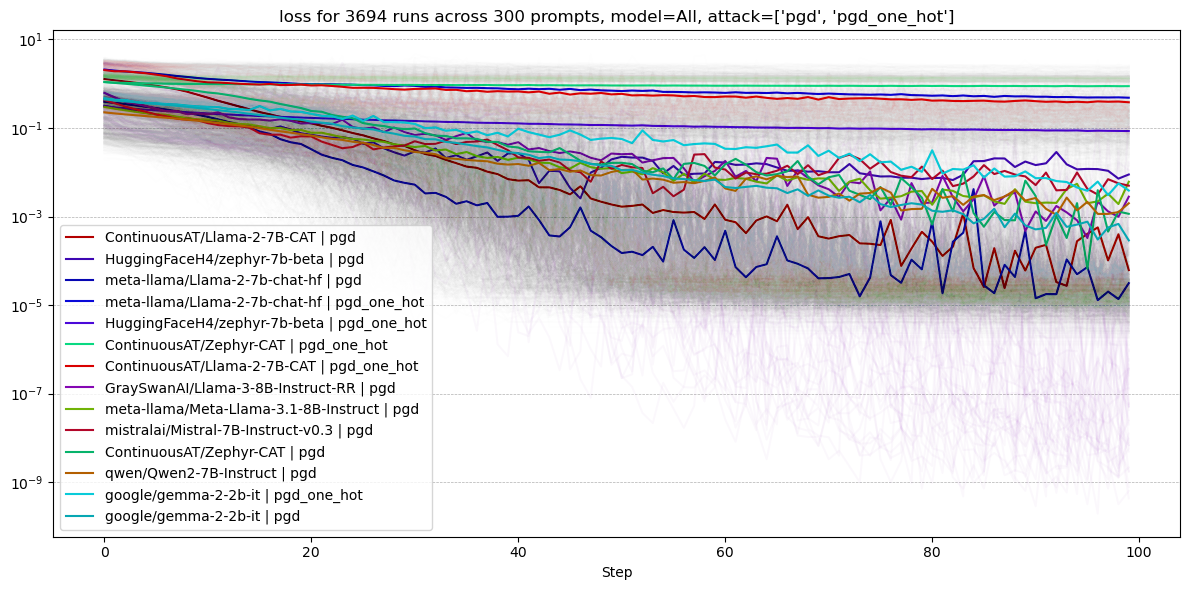

In [84]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type=['pgd','pgd_one_hot'])

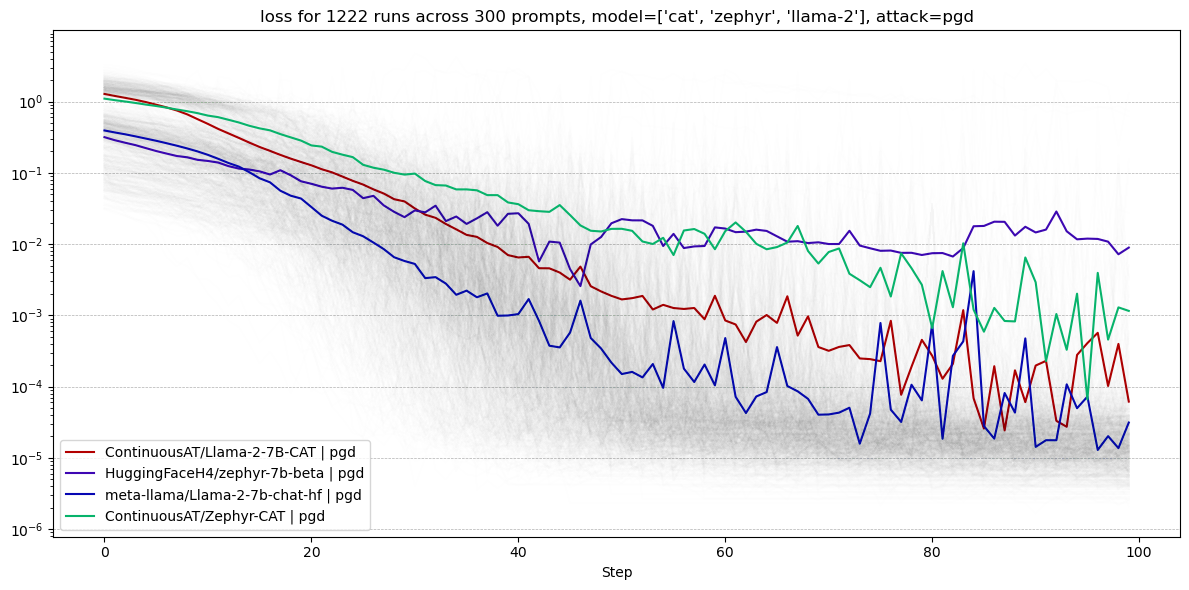

In [85]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=['cat', 'zephyr', 'llama-2'], attack_type='pgd')

In [86]:
def plot_asr(prompts, model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    n = 0
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)

        for run in prompt_runs:
            key = (run['config']['model'], run['config']['attack'])
            to_plot.setdefault(key, []).append(run['success'])

    plt.figure(figsize=(12, 6))
    y = []
    labels = []
    colors = []
    for key, values in to_plot.items():
        model, attack = key
        n += len(values)
        if attack in ('ample_gcg', 'human_jailbreaks'):
            y.append(ragged_mean([[any(v)] for v in values])[0])
        else:
            y.append(ragged_mean(values)[0]),
        labels.append(f"{model} | {attack}")
        colors.append(get_color_for_run(model, attack))
    sorted_indices = np.argsort(labels)
    sorted_labels = np.array(labels)[sorted_indices]
    sorted_y = np.array(y)[sorted_indices]
    sorted_colors = np.array(colors)[sorted_indices]

    plt.bar(sorted_labels, sorted_y, color=sorted_colors)
    for i, v in enumerate(sorted_y):
        plt.text(i, v - 0.04, f"{v:.2f}", color='white', ha='center')
    plt.title(f"success for {n} runs across {len(prompts)} prompts, model={model_name}, attack={attack_type}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

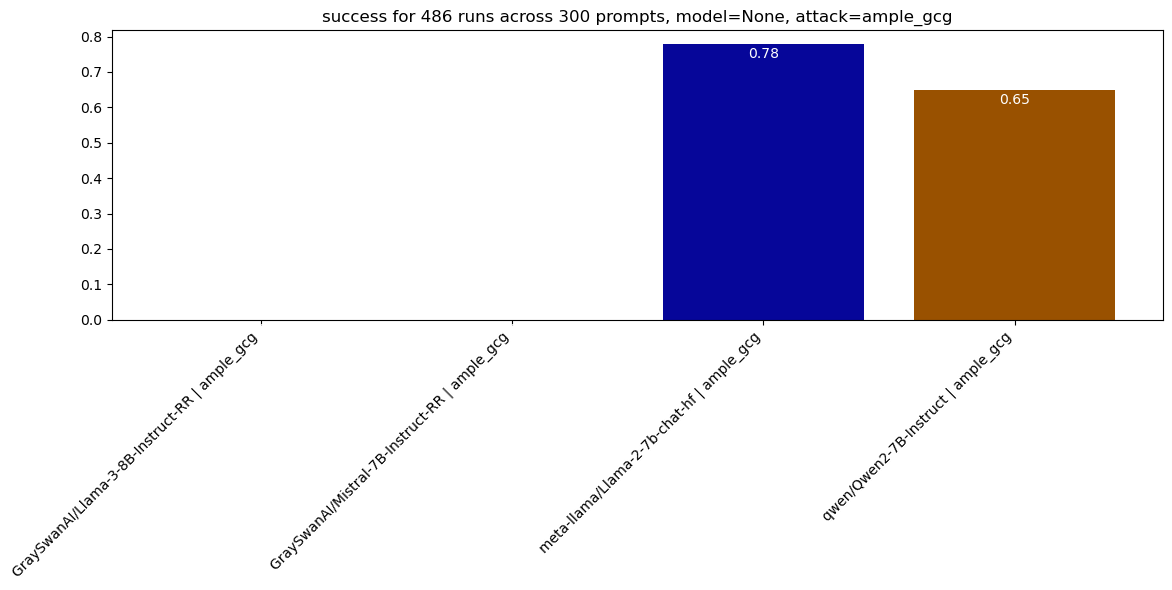

In [87]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='ample_gcg')

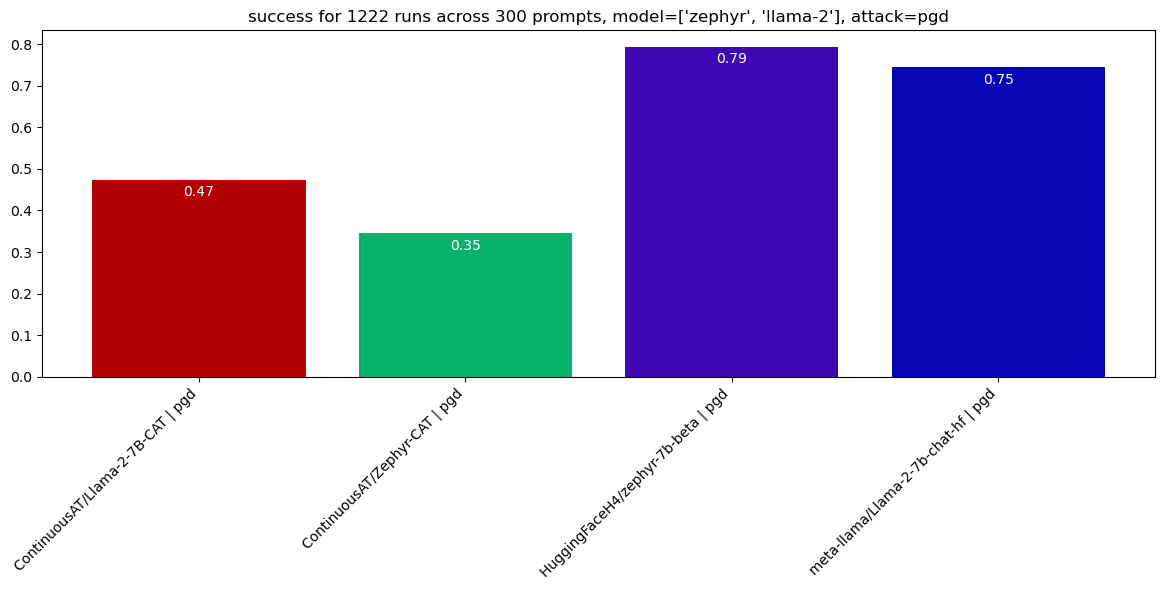

In [88]:
plot_asr([p[0]['content'] for p in d], model_name=['zephyr', 'llama-2'], attack_type='pgd')

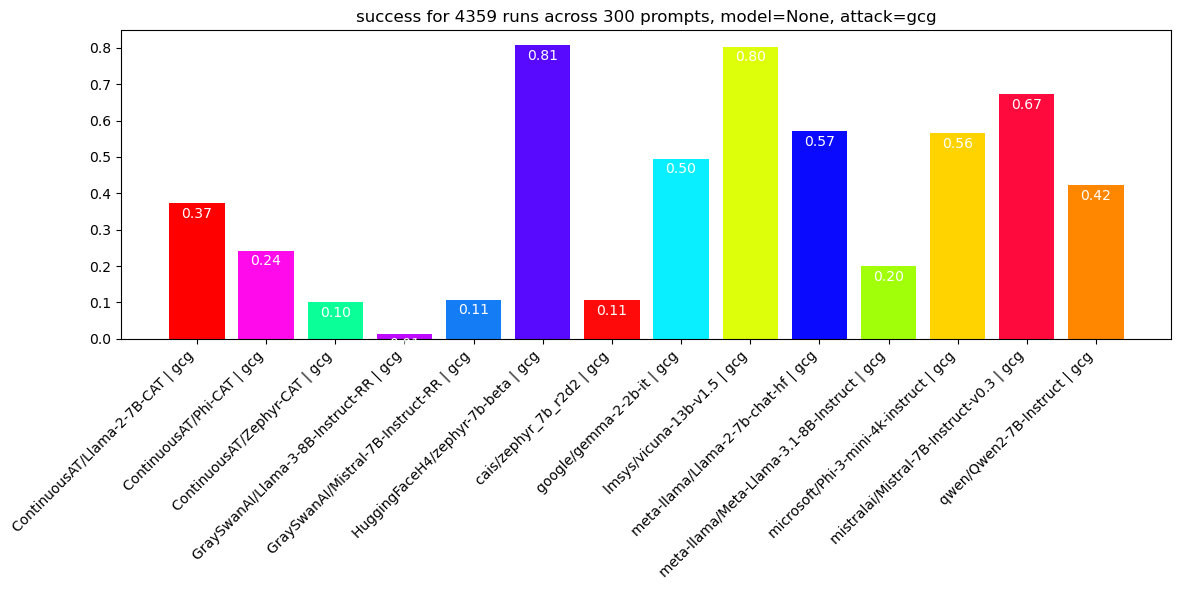

In [89]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='gcg')

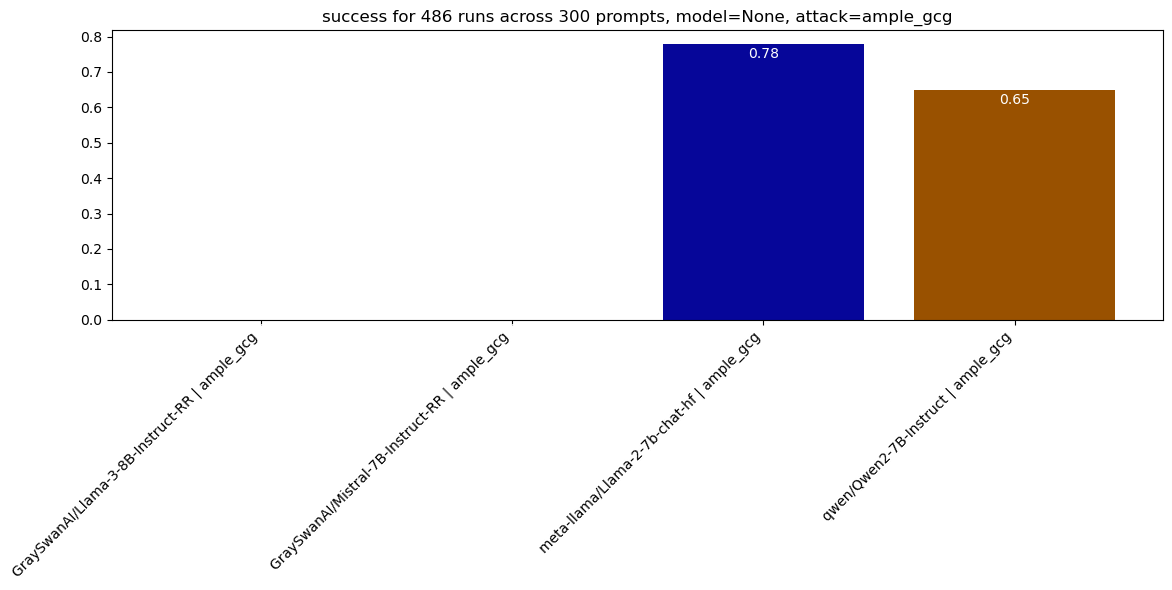

In [90]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='ample_gcg')

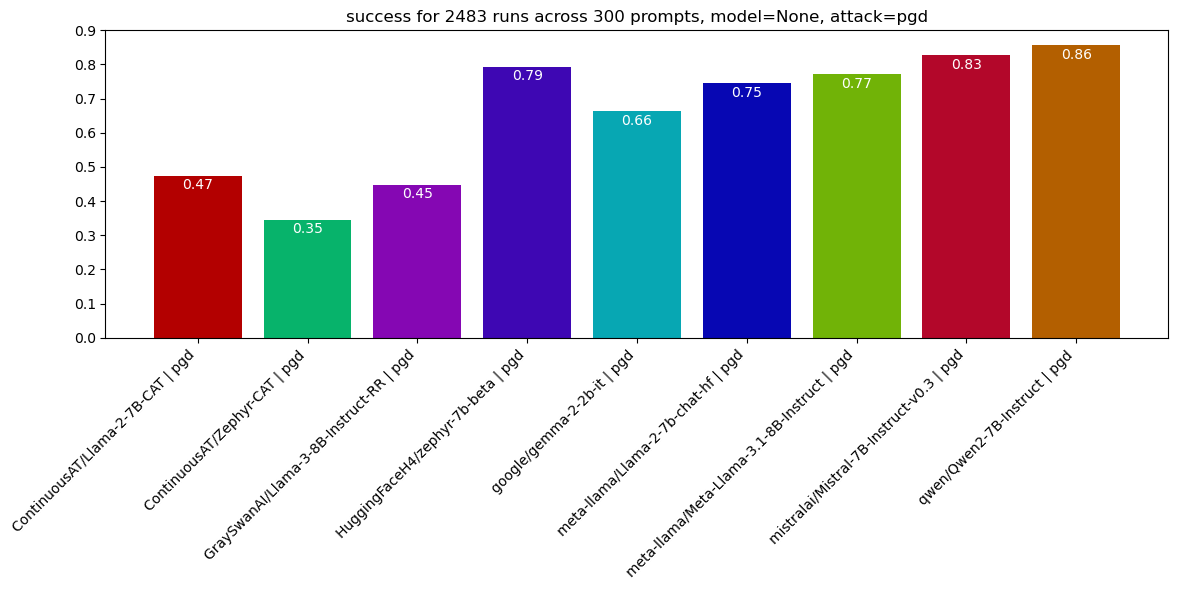

In [91]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='pgd')

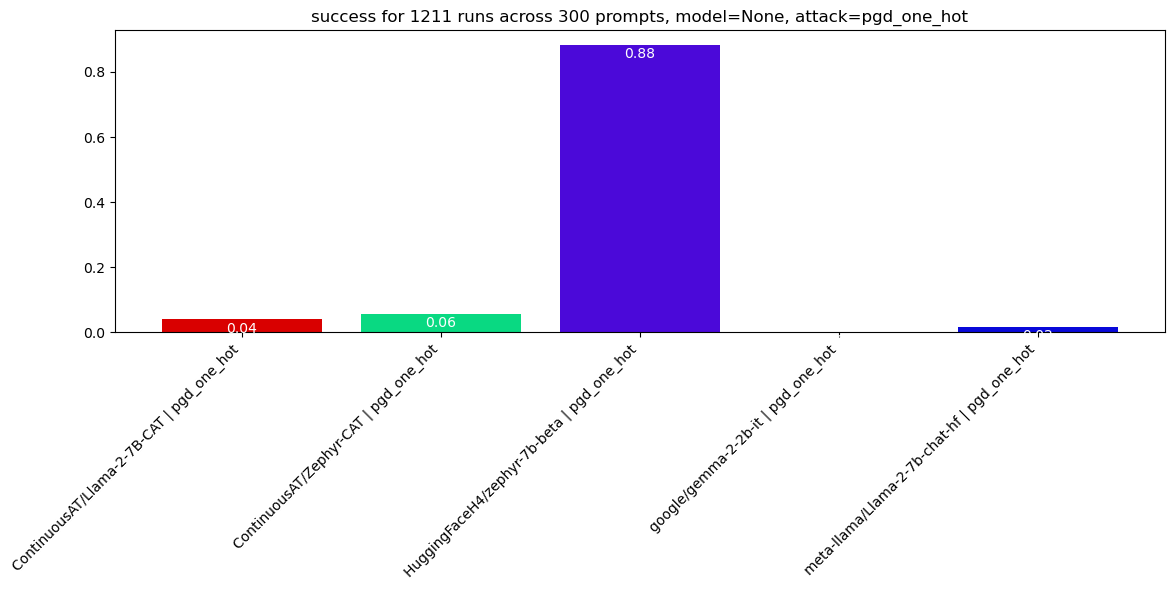

In [92]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='pgd_one_hot')

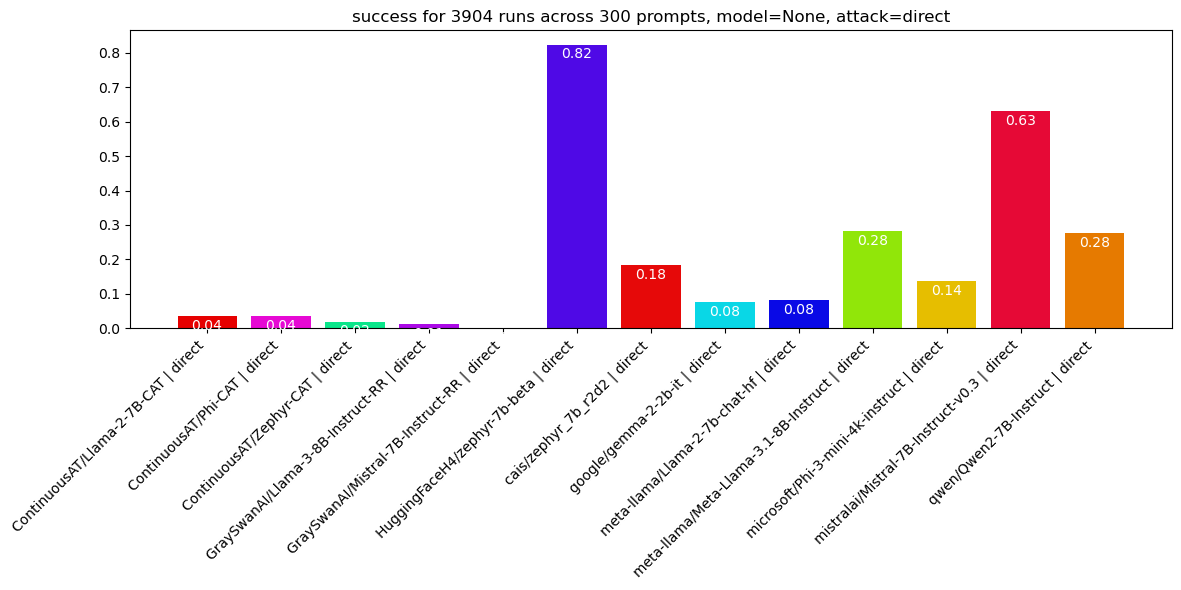

In [93]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='direct')

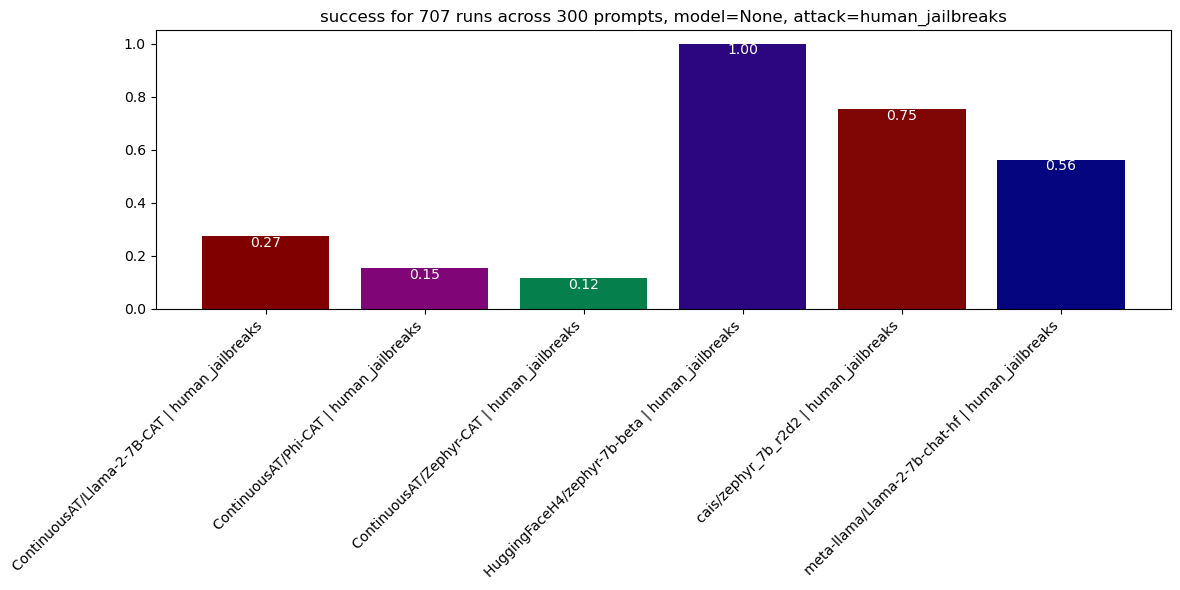

In [94]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='human_jailbreaks')

# Are some prompts harder to break than others?

In [95]:
def plot_avg_per_prompt(prompts, metric='loss', model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)
        to_plot[prompt] = [{'key': (run['config']['model'], run['config']['attack']), 'value': np.min(run[metric])} for run in prompt_runs]

    prompt_to_idx = {i: p[0]['content'] for i, p in enumerate(d)}
    data = [to_plot[prompt_to_idx[i]] for i in range(len(d)) if prompt_to_idx[i] in to_plot]
    labels = np.arange(len(data))#[f"{prompt_to_idx[i][:20].strip('\n')}..." for i in range(len(d))]

    plt.figure(figsize=(12, 6))

    if metric == 'loss':
        plt.violinplot([[d_['value'] for d_ in prompt_data] for prompt_data in data])
        plt.yscale('log')
        # Plot scatter points on top of the violins
        for i, prompt_data in enumerate(data):
            c = [get_color_for_run(*d_['key']) for d_ in prompt_data]
            plt.scatter([i + 1] * len(prompt_data), [d__['value'] for d__ in prompt_data], alpha=0.1, c=c)
    elif metric == 'success':
        plt.scatter(np.arange(1, len(data) + 1), [np.mean([d_['value'] for d_ in prompt_data]) for prompt_data in data])

    plt.xticks(ticks=np.arange(1, len(labels) + 1, step=10), labels=labels[::10], rotation=90)
    plt.ylabel(metric)
    plt.title(f"Average {metric} for {len(prompts)} prompts, model={model_name if model_name is not None else "All"}, attack={attack_type}")
    plt.xlabel("Prompt index")
    plt.legend()

/tmp/ipykernel_711656/3650824245.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


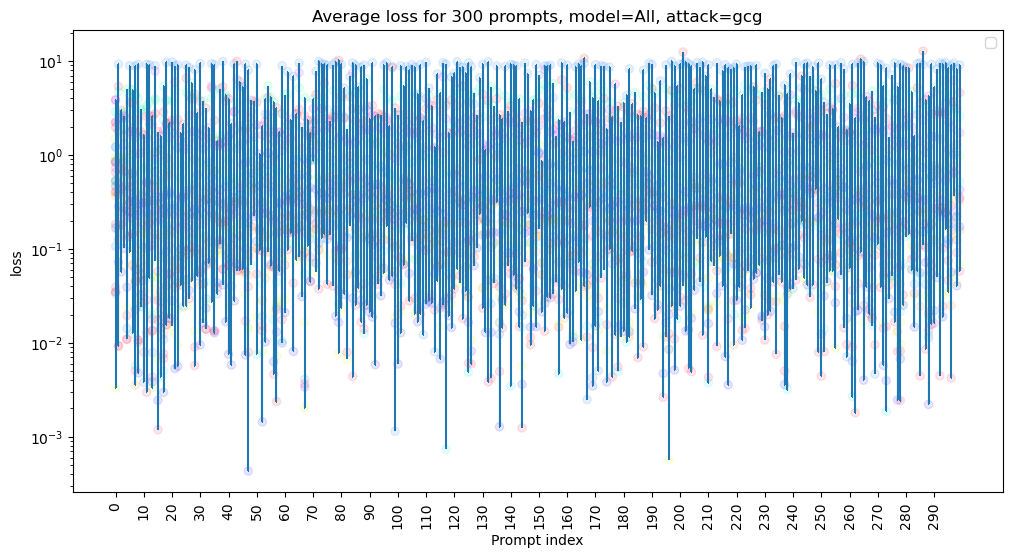

In [96]:
plot_avg_per_prompt([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='gcg')

/tmp/ipykernel_711656/3650824245.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


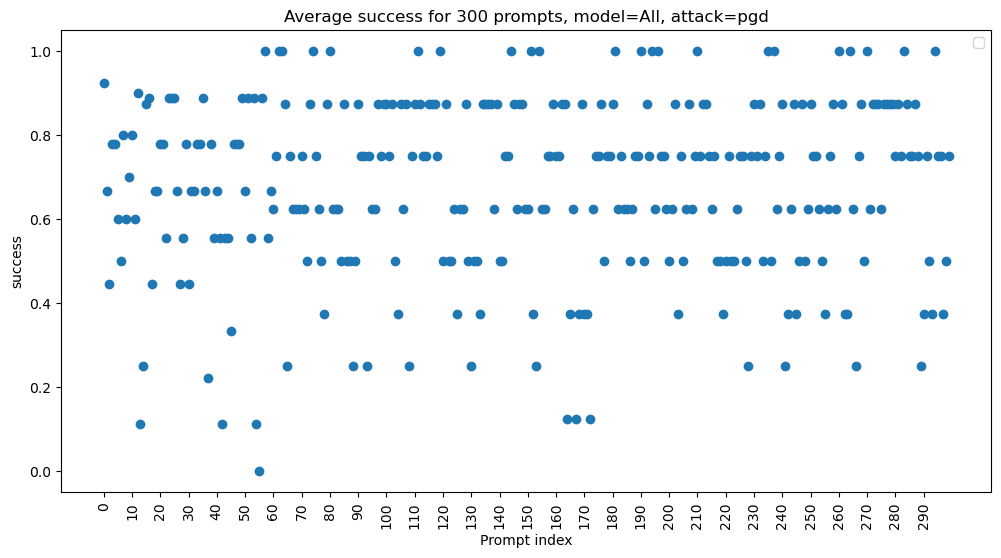

In [97]:
plot_avg_per_prompt([p[0]['content'] for p in d], 'success', model_name=None, attack_type='pgd')

# Removal/Editing 

In [98]:
delete_pattern = {
    # 'model': 'meta-llama/Llama-2-7b-chat-hf',
    'model': 'ContinuousAT/Llama-2-7B-CAT',
    'attack': 'gcg',
    # 'idx': 0,
}

data_path = '../outputs'
to_delete = []
for folder in os.listdir(data_path):
    # if folder in dates:
    for root, dirs, files in os.walk(os.path.join(data_path, folder)):
        for file in files:
            if file.endswith('run.json'):
                data = pd.read_json(os.path.join(root, file))
                for i in range(len(data)):
                    run = data.iloc[i]
                    config = run['config']
                    if all(config[k] == v for k, v in delete_pattern.items()):
                        to_delete.append(os.path.join(root, file))
                        break
print(f'Found {len(to_delete)} runs to delete.')

NameError: name 'pandas' is not defined

In [29]:
import shutil

old_outputs_path = '../old_outputs'
confirm = input(f'Are you sure you want to move {len(to_delete)} files to {old_outputs_path}? (yes, please/n) ')
if confirm != 'yes, please':
    print('Aborting...')
else:
    for file_path in to_delete:
        # Create the new directory path in old_outputs
        new_dir_path = os.path.join(old_outputs_path, os.path.relpath(file_path, '../outputs'))
        os.makedirs(os.path.dirname(new_dir_path), exist_ok=True)

        # Move the file to the new directory
        print(f'Moving {file_path} to {new_dir_path}')
        shutil.move(file_path, new_dir_path)

        # Check if the original directory is empty and delete it if it is
        original_dir = os.path.dirname(file_path)
        if not os.listdir(original_dir):
            print(f'Deleting empty directory {original_dir}')
            os.rmdir(original_dir)

Aborting...
